Michael Ricardo DS 2500 Project Treasure Hunter

In [106]:
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [107]:
def fetch_ticker_data(ticker):
    """
    Gets the market data for a given date and ticker.
    Fetches from yfinance library.

    Args:
        years ago (int): Representing the most recent day for stock entries 
        ticker(str): Representing the offical company stock ticker
    Returns
        df (DataFrame): DataFrame with Stock pricing data and history data
    """
    most_recent = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
    start_date = '2014-12-01'
    
    
    stock_data = yf.Ticker(ticker)
    returning_data = stock_data.history(start = start_date, end= most_recent)
    
    returning_data.index = returning_data.index.tz_localize(None).normalize()

    return returning_data

Addinng in Ten year, Thirteen Week, S&P 500 and VIX

In [ ]:
#Data for the IRX, Thirteen Year
ticker = '^IRX'
Thirteen_Week = fetch_ticker_data(ticker)
Thirteen_Week = Thirteen_Week.drop(columns=['Open','Dividends', 'Stock Splits', 'Volume', 'High', 'Low'])
Thirteen_Week = Thirteen_Week.rename(columns={'Close': '13_week_close'})

In [109]:
#Data for the TNX, Ten Year
ticker = '^TNX'
Ten_Year = fetch_ticker_data(ticker)
Ten_Year = Ten_Year.drop(columns=['Open','Dividends', 'Stock Splits', 'Volume'])
Ten_Year = Ten_Year.rename(columns={'High': '10_year_high', 'Low': '10_year_low', 'Close': '10_year_close'})

In [110]:
#Data for the BCOM 
ticker = '^BCOM'
Comm = fetch_ticker_data(ticker)
Comm['Comm_SMA_14'] = ta.sma(Comm['Close'], length=14) 
Comm = Comm.drop(columns=['Open', 'High', 'Low', 'Dividends', 'Stock Splits', 'Volume', 'Close'])
Comm

,Comm_SMA_14
Date,
2014-12-01,NaN
2014-12-02,NaN
2014-12-03,NaN
2014-12-04,NaN
2014-12-05,NaN
...,...
2024-11-22,97.817142
2024-11-25,97.751428
2024-11-26,97.768572


In [111]:
#VIX Data
ticker = '^VIX'
VIX = fetch_ticker_data(ticker)
VIX['VIX_SMA_14'] = ta.sma(VIX['Close'], length=14) 
VIX = VIX.drop(columns=['Open', 'High', 'Low', 'Dividends', 'Stock Splits', 'Volume', 'Close'])

Pulling external csv and prepping for merge

In [112]:
def external_csv(csv):
    '''
    Pulling in a csv, setting the 'Date column as the index and making it a proper datetime object
    Args:
        csv (CSV) - Data collection with Date column along with pricing data 
    Returns
        df (DataFrame): DataFrame     
    '''
    csv_read = pd.read_csv(csv)
    
    return csv_read

In [113]:
#CPI data CSV
cpi_csv = 'CPI_Data_10.csv'
cpi = external_csv(cpi_csv)
cpi = cpi.rename(columns={'Close': 'CPI_close'})
cpi['Date'] = pd.to_datetime(cpi['Date'])
cpi = cpi.set_index('Date')

In [114]:
#Makig CPI fill for all dataframe
full_date_range = pd.date_range(start='2014-12-01', end="2024-11-27", freq='D')
cpi = cpi.reindex(full_date_range)
cpi = cpi.ffill()
cpi.index.name = 'Date'


In [115]:
#One Year pulling in CSV
one_year_csv = '1year_bond_master.csv'
One_Year = external_csv(one_year_csv)

In [116]:
#Further cleaning needed for the 1 year, flipping the rows, eliminating % sign within each
One_Year = One_Year.iloc[::-1] 
One_Year['Close'] = One_Year['Close'].str.rstrip('%').astype(float)
One_Year = One_Year.set_index('Date')

In [117]:
#Finding MACD and saving that as the DF, only saving MACDs for now since it is most relevant 
one_year_MACD = ta.macd(One_Year["Close"], fast=12, slow=26, signal=9)
One_Year = pd.concat([One_Year, one_year_MACD], axis=1)


In [118]:
One_Year = One_Year.drop(columns=['Open', 'High', 'Low', 'Close', 'MACD_12_26_9','MACDh_12_26_9'])

Editing existing 10_year col for analysis and finding short term spread

In [119]:
#Finding Yield Staterd deviation as a measure of the securities volatility
Ten_Year['Yield_STDEV'] = Ten_Year['Yield_STDEV'] = ta.stdev(Ten_Year['10_year_close'], length = 14)

In [120]:
#Finding the spread between Long and Short term bonds/bills with the thirtteen week, droppin uneeded cols
Ten_Year['Short_Term_Spread'] = Ten_Year['10_year_close'] - Thirteen_Week['13_week_close']

Ten_Year = Ten_Year.drop(columns=['10_year_low', '10_year_high'])

Combing existing Data frames

In [121]:

def combine(df_first, dfs):
    """
    Combining the data from other indexes to be used as variabels
    Args:
        df_main (dataframe): Main secuirty which will have the others cols added
        df_1 (dataframe): Sub index which will be added to df_main, will be used for S&P 500
        df_2 (dataframe): Sub index which will be added to df_main, will be used for VIx 
    Returns:
        df_mained: Combined df_main with df1 & df2
    """
    for df in dfs:
        # Ensure indices are aligned and consistent
        df.index = pd.to_datetime(df.index)
        df_first = pd.concat([df_first, df], axis=1)
    return df_first


In [122]:
#merging the dfs from above into the 10 year bond
dfs = [VIX, One_Year, cpi, Comm]
df_first = Ten_Year
final_df = combine(df_first, dfs).dropna()
final_df

,10_year_close,Yield_STDEV,Short_Term_Spread,VIX_SMA_14,MACDs_12_26_9,CPI_close,Comm_SMA_14
Date,,,,,,,
2015-01-20,1.807,0.134184,1.799,19.477857,0.012013,234.747,103.221429
2015-01-21,1.853,0.119475,1.833,19.687143,0.008745,234.747,102.967858
2015-01-22,1.896,0.099177,1.881,19.487143,0.005734,234.747,102.772143
2015-01-23,1.817,0.082887,1.804,19.406428,0.003029,234.747,102.577143
2015-01-26,1.828,0.073557,1.823,19.092143,0.000650,234.747,102.354286
...,...,...,...,...,...,...,...
2024-11-20,4.406,0.056236,-0.004,16.714286,0.038259,315.454,97.752857
2024-11-21,4.432,0.057928,0.019,16.356429,0.039220,315.454,97.812857
2024-11-22,4.410,0.054405,-0.005,15.875000,0.040553,315.454,97.817142


In [123]:
#Low correlation between variables as needed
final_df.corr()

,10_year_close,Yield_STDEV,Short_Term_Spread,VIX_SMA_14,MACDs_12_26_9,CPI_close,Comm_SMA_14
10_year_close,1.000000,0.312663,-0.583657,-0.287788,0.240258,0.675023,0.609890
Yield_STDEV,0.312663,1.000000,-0.247659,0.319031,0.052776,0.407728,0.440247
Short_Term_Spread,-0.583657,-0.247659,1.000000,0.014401,0.211145,-0.746845,-0.143604
VIX_SMA_14,-0.287788,0.319031,0.014401,1.000000,-0.108356,0.141729,-0.039261
MACDs_12_26_9,0.240258,0.052776,0.211145,-0.108356,1.000000,0.123174,0.549294
CPI_close,0.675023,0.407728,-0.746845,0.141729,0.123174,1.000000,0.619770
Comm_SMA_14,0.609890,0.440247,-0.143604,-0.039261,0.549294,0.619770,1.000000


In [124]:
#Standerdization
X_work = ['Yield_STDEV','Short_Term_Spread'	,'VIX_SMA_14','MACDs_12_26_9','CPI_close','Comm_SMA_14']
for col in X_work:
    final_df[col] = (final_df[col] - final_df[col].mean()) / final_df[col].std()
X = final_df[['Yield_STDEV','Short_Term_Spread'	,'VIX_SMA_14','MACDs_12_26_9','CPI_close','Comm_SMA_14']]
y = final_df['10_year_close']

Regressions:

In [125]:
def linreg_predict(X, y):
    """Predicts vals for a given array, and returns dct of mse and r^2
    Args:
        Xnew: (an array, either 1-d or 2-d which includes all the $p$ predictor features, not including bias term)
        ynew: (a 1-d array which includes all corresponding response values to `Xnew`)
    Returns:
        dct: dictionary, dct of mse and r^2 vals
    """
    
    linear_regression_model = LinearRegression()
    linear_regression_model.fit(X, y)
    
    dct = {}

    dct["ypreds"] = linear_regression_model.predict(X)
    dct["resids"] = y - dct["ypreds"]
    dct["rmse"] = np.sqrt(((dct["ypreds"] - y) ** 2).mean())
    dct["r2"] = r2_score(y, dct["ypreds"])
    dct['MAE'] = mean_absolute_error(y, dct["ypreds"])

    return dct

In [126]:
#Doing Cross-Fold validation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25, test_size = 0.3)
linear_reg_output_cross_fold = linreg_predict(X_train,y_train)
residuals = linear_reg_output_cross_fold['resids']

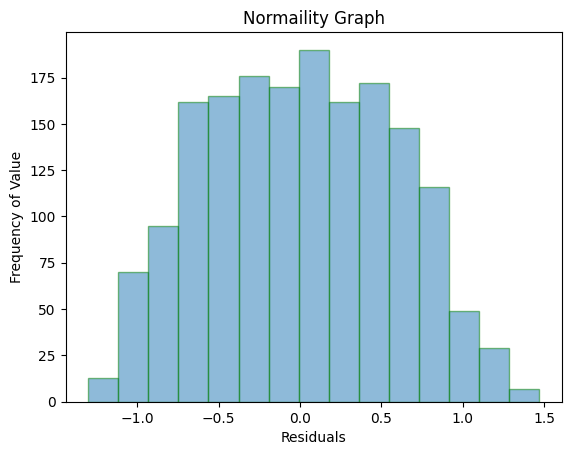

In [127]:
#Noramility
plt.hist(residuals, bins=15, edgecolor='Green', alpha=0.5)
plt.title("Normaility Graph")
plt.xlabel("Residuals")
plt.ylabel("Frequency of Value")
plt.show()

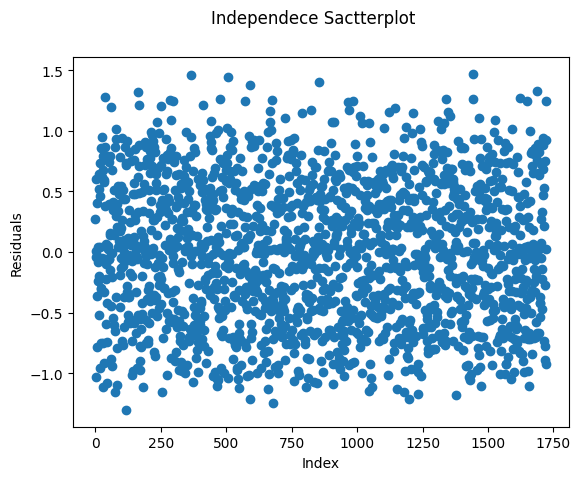

In [128]:
#Independece graph
plt.scatter(range(len(residuals)), residuals)
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.suptitle('Independece Sactterplot')
plt.show()

In [129]:
#Performing Regression on enitre dataset
linear_reg_output = linreg_predict(X,y)
residuals = linear_reg_output['resids']
ypreds = linear_reg_output['ypreds']

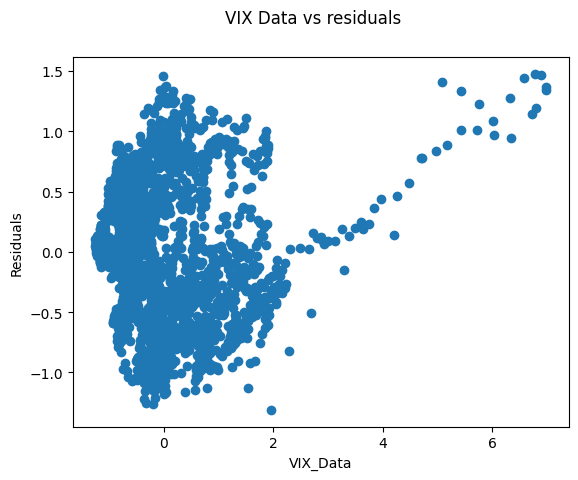

In [130]:
#VIX Data vs resids 
plt.scatter(final_df['VIX_SMA_14'], residuals)
plt.xlabel('VIX_Data')
plt.ylabel('Residuals')
plt.suptitle('VIX Data vs residuals')
plt.show()

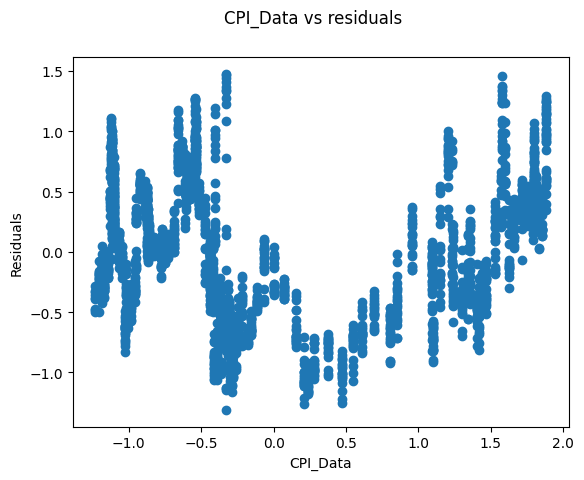

In [131]:
#CPI vs resids 
plt.scatter(final_df['CPI_close'], residuals)
plt.xlabel('CPI_Data')
plt.ylabel('Residuals')
plt.suptitle('CPI_Data vs residuals')
plt.show()

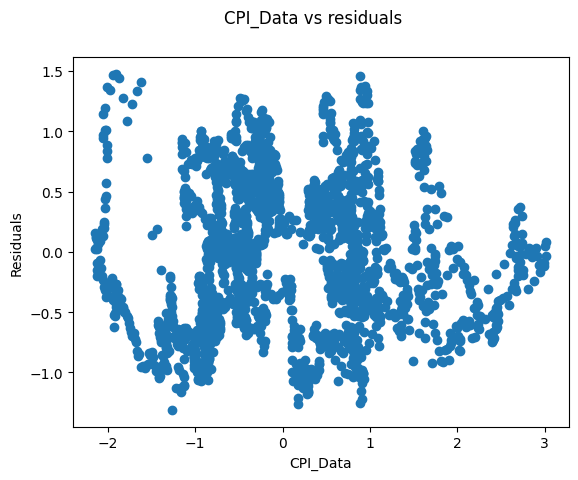

In [132]:
#Commodities vs resids 
plt.scatter(final_df['Comm_SMA_14'], residuals)
plt.xlabel('CPI_Data')
plt.ylabel('Residuals')
plt.suptitle('CPI_Data vs residuals')
plt.show()

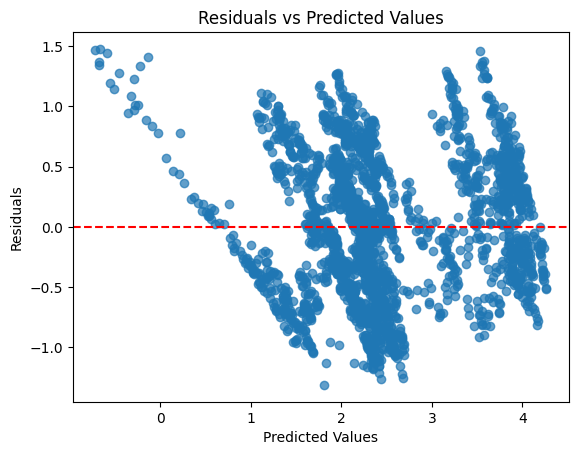

In [133]:
# Residual plot
plt.scatter(ypreds, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

In [134]:
from sklearn.preprocessing import PolynomialFeatures

#Perfomring Polynomeial regression 
poly_fit = PolynomialFeatures(degree = 4, include_bias = False)
X_poly = poly_fit.fit_transform(X)
multiple_reg = linreg_predict(X_poly,y)
multiple_reg


{'ypreds': array([1.90463637, 1.81113875, 1.80901453, ..., 4.41825006, 4.49450135,
        4.49181917]),
 'resids': Date
 2015-01-20   -0.097636
 2015-01-21    0.041861
 2015-01-22    0.086985
 2015-01-23   -0.013485
 2015-01-26    0.001523
                 ...   
 2024-11-20    0.019366
 2024-11-21    0.054812
 2024-11-22   -0.008250
 2024-11-25   -0.229501
 2024-11-26   -0.189819
 Name: 10_year_close, Length: 2464, dtype: float64,
 'rmse': 0.10289365174076935,
 'r2': 0.9902929152090435,
 'MAE': 0.07865128205047932}

Check for heteroscadasity

Use non-linear models 

#Source for MACD
https://tradingstrategy.ai/docs/api/technical-analysis/momentum/help/pandas_ta.momentum.macd.html

#Data source for One-Year Treasury
https://www.marketwatch.com/investing/bond/tmubmusd01y/download-data?countrycode=bx&mod=mw_quote_tab 

#Yfinance
https://pypi.org/project/yfinance/

#CPI
https://fred.stlouisfed.org/series/CPIAUCSL